In [28]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import sys
import os
from PIL import Image
import pickle

In [29]:
original = pickle.load(open('meshwrite/batch_final.pkl', 'rb'))
altered = pickle.load(open('meshwrite/pert_final.pkl', 'rb'))

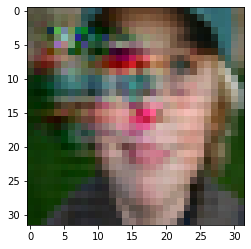

In [30]:


plt.imshow(altered[31])

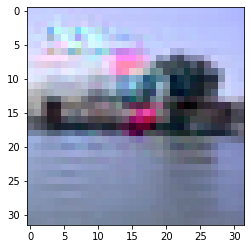

In [31]:
plt.imshow(altered[81])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


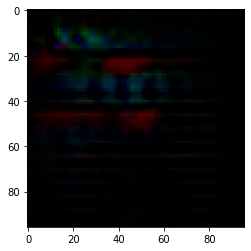

In [100]:
mask32 = altered[31] - original[31]

mask32 = cv2.resize(mask32,(96,96))
plt.imshow(mask32)

In [101]:
background = np.zeros((450,800,3))

x_offset=350
y_offset=125
background[y_offset:y_offset+mask32.shape[0], x_offset:x_offset+mask32.shape[1]] = mask32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


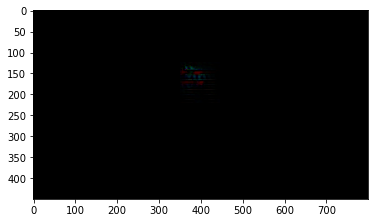

In [102]:

plt.imshow(background)

In [103]:
im = cv2.imread('data/1.tif')
im2 = im.copy()

im2[y_offset:y_offset+mask32.shape[0], x_offset:x_offset+mask32.shape[1]] = mask32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


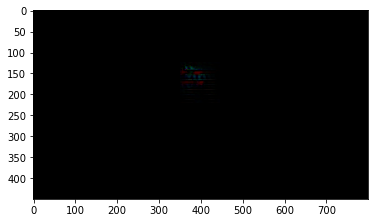

In [104]:

plt.imshow(background, cmap = 'gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


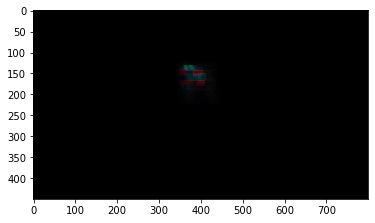

In [105]:
kernel = np.ones((7,7))

dilated = cv2.dilate(background, kernel)

plt.imshow(dilated)

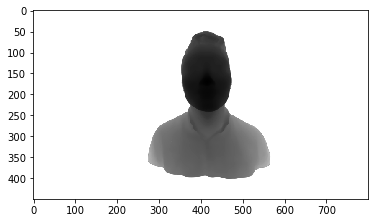

In [122]:
imz = cv2.imread('data/1z.tif', 0)

plt.imshow(imz, cmap = 'gray')

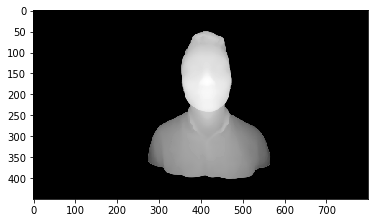

In [123]:
imzinv = 255 - imz

plt.imshow(imzinv, cmap = 'gray')

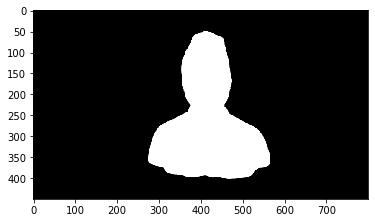

In [115]:
ima = cv2.imread('data/1a.tif', 0)

plt.imshow(ima, cmap = 'gray')

In [116]:
h, w = ima.shape

In [117]:
print(im.shape)
print(imz.shape)



(450, 800, 3)


NameError: name 'imz' is not defined

(450, 800, 3)


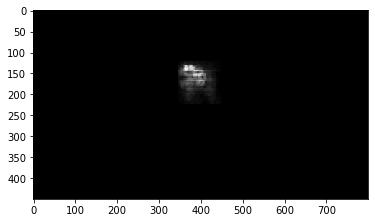

In [151]:
dilated_gray = (np.average(dilated, axis = 2) * 255).astype(int)
print(dilated.shape)
plt.imshow(dilated_gray, cmap = 'gray')

dilated_gray.shape

scalingFactor = 1500.0 + dilated_gray*2

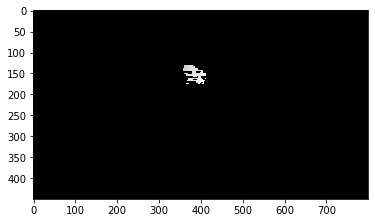

In [152]:
zmask = imzinv.copy()
zmask[np.where(dilated_gray < 25)] = 0

plt.imshow(zmask, cmap='gray')

In [153]:
focalLength = 90.0
centerX = w / 2.0
centerY = h / 2.0



Z = zmask / scalingFactor

Xrang = np.arange(0,w,1)
Yrang = np.arange(0,h,1)
imXY = np.meshgrid(Xrang, Yrang)

print(imXY[0], imXY[1])

[[  0   1   2 ... 797 798 799]
 [  0   1   2 ... 797 798 799]
 [  0   1   2 ... 797 798 799]
 ...
 [  0   1   2 ... 797 798 799]
 [  0   1   2 ... 797 798 799]
 [  0   1   2 ... 797 798 799]] [[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [447 447 447 ... 447 447 447]
 [448 448 448 ... 448 448 448]
 [449 449 449 ... 449 449 449]]


In [154]:


X = (imXY[0] - centerX) * Z / focalLength
Y = (imXY[1] - centerY) * Z / focalLength

Xworld = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T
# def generate_pointcloud(rgb_file,depth_file,ply_file):

#     rgb = Image.open(rgb_file)
#     depth = Image.open(depth_file).convert('I')

#     if rgb.size != depth.size:
#         raise Exception("Color and depth image do not have the same 
# resolution.")
#     if rgb.mode != "RGB":
#         raise Exception("Color image is not in RGB format")
#     if depth.mode != "I":
#         raise Exception("Depth image is not in intensity format")


#     points = []    
#     for v in range(rgb.size[1]):
#         for u in range(rgb.size[0]):
#             color = rgb.getpixel((u,v))
#             Z = depth.getpixel((u,v)) / scalingFactor
#             print(Z)
#             if Z==0: continue
#             X = (u - centerX) * Z / focalLength
#             Y = (v - centerY) * Z / focalLength
#             points.append("%f %f %f %d %d %d 0\n"% 
                   
print(Xworld.shape)

(360000, 3)


In [155]:
Xworld

array([[-0., -0.,  0.],
       [-0., -0.,  0.],
       [-0., -0.,  0.],
       ...,
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

Text(0.5, 0.92, 'Recovered World Points')

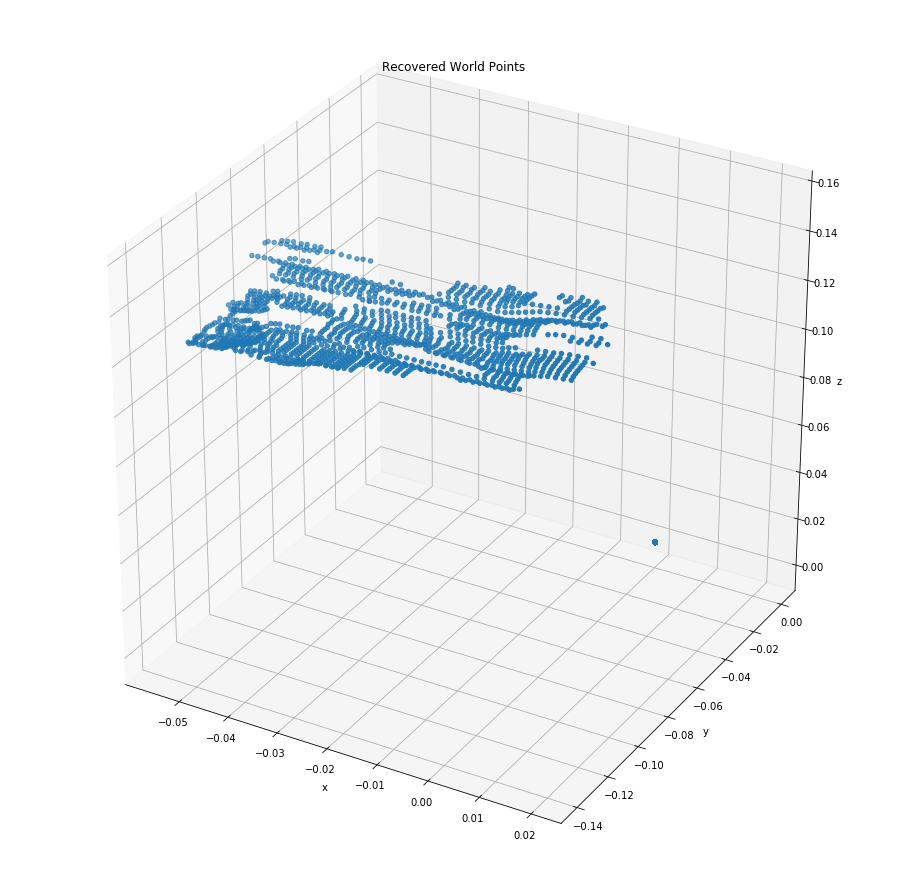

In [156]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

plt.figure(figsize=(16,16))
ax = plt.axes(projection='3d')
ax.scatter(Xworld[:,0],Xworld[:,1],Xworld[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Recovered World Points')

In [157]:
pd.DataFrame(Xworld, columns = ['X', 'Y', 'Z'])

X    Y    Z
0      -0.0 -0.0  0.0
1      -0.0 -0.0  0.0
2      -0.0 -0.0  0.0
3      -0.0 -0.0  0.0
4      -0.0 -0.0  0.0
...     ...  ...  ...
359995  0.0  0.0  0.0
359996  0.0  0.0  0.0
359997  0.0  0.0  0.0
359998  0.0  0.0  0.0
359999  0.0  0.0  0.0

[360000 rows x 3 columns]

In [158]:
Xworldsmall = cv2.resize(Xworld.reshape(450,800,3),(9,16))

In [159]:
Xworldsmall.shape

(16, 9, 3)

In [93]:
Xworldsmallflat = Xworldsmall.reshape(Xworldsmall.shape[0]*Xworldsmall.shape[1], 3)

In [94]:
Xworldsmallflat.shape

(144, 3)

In [160]:
X = Xworld.reshape(450, 800, 3)

In [162]:
def get_mesh(X, Xflat):
    
    triangles = []
    uv = []
    vertices = []
    count = 0
    maps = {}
    
    for i in range(X.shape[0] - 1):

        for j in range(X.shape[1]):

            curr = (i)*X.shape[1]+j
            right = (i)*X.shape[1]+j+1
            below = (i+1)*X.shape[1]+j
            left = (i+1)*X.shape[1]+j-1
            black = [0,0,0]
            
            curr_notblack = np.linalg.norm(Xflat[curr] - black) != 0
            right_notblack = np.linalg.norm(Xflat[right] - black) != 0
            below_notblack = np.linalg.norm(Xflat[below] - black) != 0
            left_notblack = np.linalg.norm(Xflat[left] - black) != 0
            
            if curr_notblack:
                vertices.append(Xflat[curr])
                uv.append([i,j])
                maps[curr] = count
                count += 1

            

            if j is 0:
                if curr_notblack and right_notblack and below_notblack:
                    triangles.append([curr, right,below ])
            elif j is X.shape[1]-1:
                if curr_notblack and below_notblack and left_notblack:
                    triangles.append([curr, below, left])
            else:
                if curr_notblack and right_notblack and below_notblack:
                    triangles.append([curr, right,below])
                if curr_notblack and below_notblack and left_notblack:
                    triangles.append([curr, below, left])
    
    i = X.shape[0] - 1
    for j in range(X.shape[1]):
        curr = (i)*X.shape[1]+j
        if curr_notblack:
                vertices.append(Xflat[curr])
                uv.append([i,j])
    
    
    
    return triangles, vertices, uv , maps

In [163]:
triangles, vertices, uv, maps = get_mesh(X, Xworld)

In [164]:
tri = pd.DataFrame(np.array(triangles).flatten(), columns = ['X'])
len(tri['X'].unique())

1389

In [165]:
trgles = pd.DataFrame(triangles, columns = ['one', 'two', 'three'])

for row in trgles.iterrows():
    row[1]['one'] = maps[row[1]['one']]
    row[1]['two'] = maps[row[1]['two']]
    row[1]['three'] = maps[row[1]['three']]

trgles

one   two  three
0        0     1     18
1        1     2     19
2        1    19     18
3        2     3     20
4        2    20     19
...    ...   ...    ...
2343  1383  1400   1399
2344  1384  1385   1401
2345  1384  1401   1400
2346  1395  1396   1402
2347  1399  1400   1403

[2348 rows x 3 columns]

In [168]:
vts = np.array(vertices)
uvs = np.array(uv)

pts = np.hstack((vts, uvs))
print(vts.shape)

(1404, 3)


In [169]:
points = pd.DataFrame(vts, columns = ['x','y','z'])
uvdefs = pd.DataFrame(uvs, columns = ['u','v'])

In [170]:
x = [1,1,1]
y = [1,1,1]

print(x == y)

True


In [171]:
trgles.to_csv('triangles.csv')
points.to_csv('points.csv')
uvdefs.to_csv('uvs.csv')

In [49]:
len(vertices)

20

In [50]:
len(uv)

20

In [32]:
black = [0.0, 0.0, 0.0]
print(np.linalg.norm(Xworldsmallflat[0] - black) == 0)

True


In [37]:
Xworldsmallflat

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   